In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

In [43]:
url = "https://www.cenace.gob.mx/graficademanda.aspx"
clave_region = ["ccbc", "ccbcsur", "cccentral", "ccnoreste", "ccnoroeste", 
                "ccnorte", "ccoccidental", "ccoriental", "ccpeninsular", "sinacional"]
regiones = ['Baja California', 'Baja California Sur', 'CENTRAL', 'NORESTE', 'NOROESTE', 
            'NORTE', 'OCCIDENTAL', 'ORIENTAL', 'PENINSULAR', 'S.I. NACIONAL']
datos = []
fecha = datetime.datetime.now().strftime("%d-%m-%Y %H_%M_%S")

In [35]:
def obtener_contenido(url):
    """
    Obtiene el contenido HTML de una página web a través de una solicitud HTTP GET.

    Args:
        url (str): La URL de la página web de la cual se desea obtener el contenido.

    Returns:
        bytes: El contenido de la página web en formato binario (bytes).

    Raises:
        Exception: Si ocurre algún error durante la solicitud HTTP.
    """
    pagina_web = requests.get(url)
    return pagina_web.content

In [36]:
def genera_soup(contenido_web):
     """
    Genera un objeto BeautifulSoup a partir del contenido HTML proporcionado.

    Args:
        contenido_web (bytes): El contenido HTML de la página web en formato binario (bytes).

    Returns:
        BeautifulSoup: Un objeto BeautifulSoup creado a partir del contenido HTML.
    """
     return BeautifulSoup(contenido_web, "html.parser")

In [37]:
def extraccion_pagina(soup):
     """
    Extrae datos de generación y demanda de energía eléctrica de una página web usando BeautifulSoup.

    Args:
        soup (BeautifulSoup): Un objeto BeautifulSoup creado a partir del contenido HTML de la página web.
        clave_region (list): Lista de clases utilizadas para identificar las regiones en la página.
        fecha (str): Fecha asociada a los datos extraídos.

    Returns:
        pandas.DataFrame: Un DataFrame con los datos extraídos, incluyendo generación, demanda y diferencia.
    """
          
     for clave in clave_region:
        
      titulo_region = soup.find("li", class_ = clave)
      region = titulo_region.select_one(".titlex").text

      p_tags = soup.select("li." + clave + " p") # Selecciono las 3 etiquetas p
      for p_tag in p_tags:
            if "Demanda Neta:" in p_tag.text:
                 demanda_neta = float(p_tag.select_one(".bold").text.replace(",","")[:-3]) 
            elif "Generación Neta:" in p_tag.text:
                 generacion_neta = float(p_tag.select_one(".bold").text.replace(",","")[:-3])              
               
      datos.append({
              "Fecha" : fecha,
              "Región": region,
              "Generación Neta MW" : generacion_neta,
              "Demanda Neta MW" : demanda_neta,
              "Diferencia MW" : generacion_neta - demanda_neta
              })
      
     return pd.DataFrame(datos)

In [38]:
def actualizar_datos(df):
    """
    Actualiza los datos existentes en un archivo CSV con nuevos datos y crea una nueva versión del archivo.

    Args:
        df (pandas.DataFrame): DataFrame con los nuevos datos a ser agregados al archivo existente.
        fecha (str): Fecha asociada a los nuevos datos.

    Returns:
        None
    """

    documentos = os.listdir("../csv")
    documentos.sort(key=lambda x: os.path.getmtime(os.path.join("../csv", x)))
    
    n_update = int(documentos[-1].split()[0])
    new_n_update = str(n_update + 1)
    ultimo = documentos[-1]
    fecha_actual = fecha

    df_base = pd.read_csv("../csv/" + ultimo)
    df_nuevo = pd.concat([df_base,df], ignore_index=True)

    columnas = ["Fecha", "Región", "Generación Neta MW", "Demanda Neta MW", "Diferencia MW"]
    df_nuevo = df_nuevo[columnas]
    df_nuevo.to_csv("../csv/" + new_n_update + " " + fecha_actual + ".csv")

In [39]:
def proceso_datos(url):
    """
    Realiza el proceso completo de obtención, extracción y actualización de datos energéticos.

    Args:
        url (str): La URL de la página web de la cual se obtendrán los datos.
        fecha_actualizacion (str): Fecha asociada a los nuevos datos.

    Returns:
        None
    """
    contenido_web = obtener_contenido(url)
    soup = genera_soup(contenido_web)
    df = extraccion_pagina(soup)
    actualizar_datos(df)    

In [44]:
proceso_datos(url)

In [47]:
# Obtiene el df del ultimo csv de la base
documentos = os.listdir("../csv")
documentos.sort(key=lambda x: os.path.getmtime(os.path.join("../csv", x)))
ultimo = documentos[-1] 
df_general = pd.read_csv("../csv/" + ultimo)
df = df_general[["Fecha", "Región", "Generación Neta MW", "Demanda Neta MW", "Diferencia MW"]]

# Formato a fechas
df_general["Fecha"] = pd.to_datetime(df_general["Fecha"], format="%d-%m-%Y %H_%M_%S")
df_general["Hora"] = df_general["Fecha"].dt.strftime("%H")
df_general["Día"] = df_general["Fecha"].dt.strftime("%d-%m-%Y")
df_general = df_general.sort_values(by = "Hora")

df = pd.DataFrame(df_general)

# Filtra a un tipo de region para ejemplo
df = df[df["Región"] == "S.I. NACIONAL"]

# Calculos para graficar
media_generacion = round(df["Generación Neta MW"].mean(),2)
media_demanda = round(df["Demanda Neta MW"].mean(), 2)
max_demanda = max(df["Demanda Neta MW"])
min_demanda = min(df["Demanda Neta MW"])
media_demanda = round(np.mean(df["Demanda Neta MW"]),1)
max_generacion = max(df["Generación Neta MW"])
min_generacion = min(df["Generación Neta MW"])
puntos_medios = (df["Generación Neta MW"] + df["Demanda Neta MW"])/2
diferencia = list(df["Generación Neta MW"] - df["Demanda Neta MW"])
dia = df["Día"].iloc[-1]
hora = df["Hora"].iloc[-1]

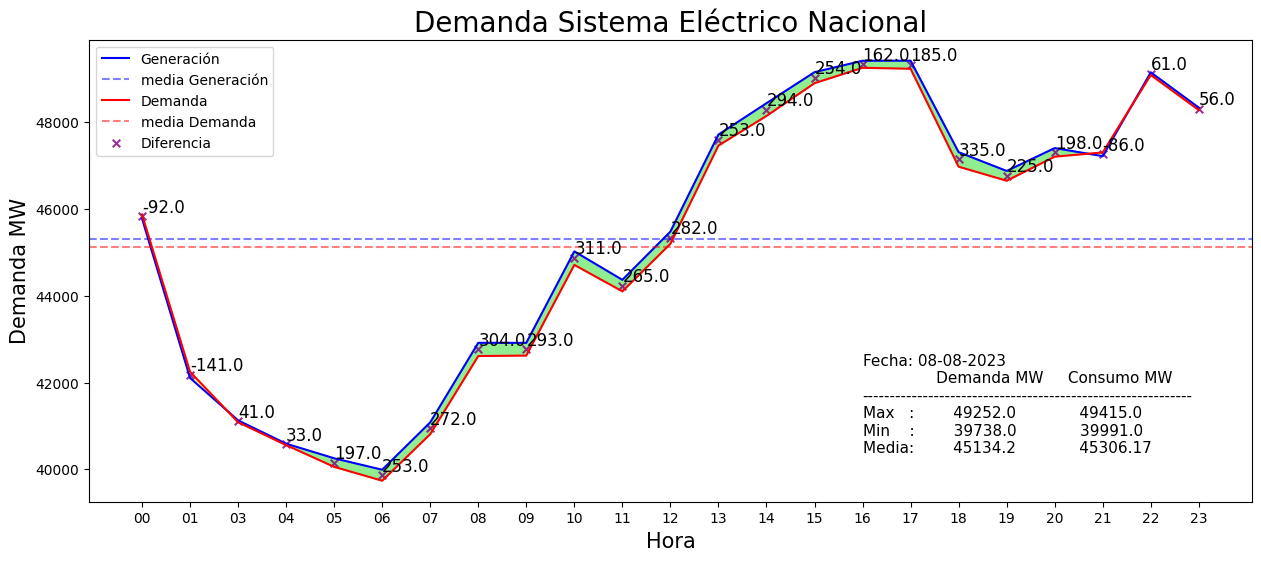

In [49]:
# Grafica
plt.figure(figsize=(15, 6)) 

# Generación
plt.plot(df["Hora"], df["Generación Neta MW"], label = "Generación", color = "blue")
plt.axhline(y=media_generacion, label="media Generación", linestyle="--", color="blue", alpha=0.5)

# Demanda
plt.plot(df["Hora"], df["Demanda Neta MW"], label = "Demanda", color = "red")
plt.axhline(y=media_demanda, label="media Demanda", linestyle="--", color="red", alpha=0.5)

# Área generacion >= Demanda
plt.fill_between(df["Hora"], df["Generación Neta MW"], df["Demanda Neta MW"], where=(df["Generación Neta MW"] >= df["Demanda Neta MW"]), interpolate=True, color="lightgreen")
# Área generacion < Demanda
plt.fill_between(df["Hora"], df["Generación Neta MW"], df["Demanda Neta MW"], where=(df["Generación Neta MW"] < df["Demanda Neta MW"]), interpolate=True, color="yellow", alpha = .45)

# Diferencias
plt.scatter(df["Hora"], puntos_medios , label = "Diferencia", marker = "x", s = 30, alpha = 0.8, color = "purple") # figuras x
for i, valor in enumerate(puntos_medios):
    plt.text(df["Hora"].iloc[i], valor+100, f"{diferencia[i]}", fontsize = 12)
   
tabla_info = f"""
Fecha: {dia}
{'':<15}Demanda MW{'':<5}Consumo MW{'':<15}
{'-'*60:<15}
{'Max   :':<15}{max_demanda:<20}{max_generacion:<15}
{'Min    :':<16}{min_demanda:<20}{min_generacion:<15}
{'Media:':<14}{media_demanda:<20}{media_generacion:<15}
"""
plt.text(df["Hora"].iloc[-8], min_generacion, tabla_info, fontsize=11)

plt.title("Demanda Sistema Eléctrico Nacional", fontsize = 20)
plt.xlabel("Hora", fontsize = 15)
plt.ylabel("Demanda MW", fontsize = 15)

plt.legend(loc = "upper left")
plt.savefig("../img/"+ fecha.split()[0] + ".png")
plt.show()